# Python para finanças - precificação de ativos

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px

In [ ]:
from get_stocks_yfinance import get_stocks_yfinance
from constants import stocks
dataset, days = get_stocks_yfinance(stocks)

In [ ]:
dataset

In [ ]:
normalized_dataset = dataset.copy()
for column in normalized_dataset.columns:
  normalized_dataset[column] = normalized_dataset[column] / normalized_dataset.loc[normalized_dataset.index[0], column]
normalized_dataset

In [ ]:
# Return rate dataset
rr_dataset = pd.DataFrame(None)
for column in normalized_dataset.columns:
    rr_dataset[column] = normalized_dataset[column] / normalized_dataset[column].shift(1) - 1
rr_dataset = rr_dataset.fillna(0)
rr_dataset.mean()
rr_dataset

# CAPM

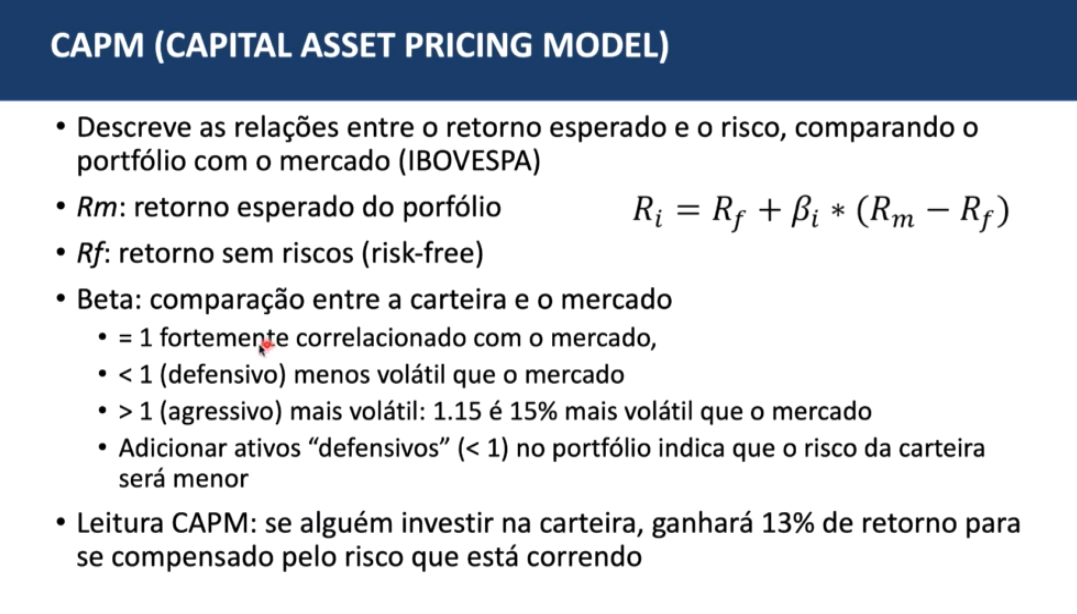

# Cálculo do parâmetro BETA para um ativo

## Linear regression

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

stock_exchange_index = rr_dataset.columns[0]
all_stocks_to_compare = rr_dataset.columns[1:]
number_of_rows = int(np.ceil((len(rr_dataset.columns) - 1) / 2))
titles = [f"{stock_exchange_index} X {stock}" for stock in all_stocks_to_compare]

fig = make_subplots(rows=number_of_rows, cols=2, subplot_titles=titles)

for i, column in enumerate(rr_dataset.columns[1:]):
    row = (i // 2) + 1
    col = (i %  2) + 1
    fig.append_trace(
        go.Scatter(
            x=rr_dataset[stock_exchange_index], 
            y=rr_dataset[column], 
            mode='markers'
        ),
        row=row, 
        col=col
    )
    # Update xaxis properties
    fig.update_xaxes(title_text=stock_exchange_index, row=row, col=col)
    fig.update_yaxes(title_text=column, row=row, col=col)

fig.update_layout(showlegend=False)
fig.show()

### Beta indica o quão mais volatil que o mercado a ação é, exemplo beta = 1.128 -> acção 12,8% mais volátil que o mercado

In [ ]:
beta, alpha = np.polyfit(
    x = rr_dataset[stock_exchange_index], 
    y = rr_dataset[all_stocks_to_compare[0]], 
    deg=1 # 100% linear
)
print(beta, alpha)

In [ ]:
fig = px.scatter(
    rr_dataset, 
    x=stock_exchange_index, 
    y=all_stocks_to_compare[0], 
    title=f"{stock_exchange_index} X {all_stocks_to_compare[0]}"
)
fig.add_scatter(x = rr_dataset[stock_exchange_index], y= beta * rr_dataset[stock_exchange_index] + alpha)
display(fig)

## CAPM Pode ser interpretado da seguinte forma: Se alguém investir na EMPRESA X, será compensado em X_CAPM pelo risco que está correndo

# CAPM Para todos os ativos

In [ ]:
betas: list[float] = []
alphas: list[float] = []
rf: float = 0
rm: float = 0
capms: dict[str, float] = dict()
# * FROM FORMULA: CAPM = R_f + B_i * (R_m - R_f)
# Calculate betas and alphas (beta = B_i)
for column in ["QQQ", "QUAL", "IVV"]:
    beta, alpha = np.polyfit(x = rr_dataset["S&P 500"], y = rr_dataset[column], deg=1)
    betas.append(beta)
    alphas.append(alpha)
# Calculate rr (Rf = Risk Free)
selic_rates = np.array((
    0.1275, # 2015
    0.1425, # 2016
    0.1225, # 2017
    0.0650, # 2018
    0.050, # 2019
    0.020, # 2020
    0.0775, # 2021
    0.1375, # 2022
    0.12, # 2023
))
rf = selic_rates.mean()

cov_matrix = rr_dataset.drop(columns = []).cov() * 250

for column in ["QQQ", "QUAL", "IVV"]:
    cov = cov_matrix.loc["S&P 500", column]
    sp_var = rr_dataset['S&P 500'].var() * 250
    beta = cov / sp_var
    rm = rr_dataset["S&P 500"].mean() * 250

    capm = rf + beta * (rm - rf)
    capms[column] = capm

capms